In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import random
import numpy as np
import cv2
import base64
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from copy import deepcopy
from torch.autograd import Variable
from tqdm import tqdm
from pprint import pprint
from PIL import Image
from time import localtime, strftime
from sklearn.model_selection import train_test_split
import os

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Training on',DEVICE)

Training on cpu


In [3]:
# print(model) does not provide output dimensions like keras summary - Hence use torchsummary
#!pip install torchsummary

In [4]:
import random
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = False


In [5]:
import copy
import os
#import random
import shutil
#import time
from zipfile import ZipFile
import  pathlib
from os import walk
import time

In [6]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader, random_split


In [7]:
# X_train = np.array(train_data / 255, dtype='float32')
# X_val = np.array(test_data / 255, dtype='float32')


In [8]:
IMG_SIZE = 160

In [9]:
# instantiate a GAN's Discriminator

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        modules = []
        hidden_dims = [64, 128, 256, 512, 1024] # V2
        Discriminator_LayerNorm_hw_list = [ [80,80] , [40,40] ,  [20,20] , [10,10] , [5,5] ]


        # similar to  the encoder code   above, but the final FC will have 1 neuron and sigmoid...

        norm_idx=0
        in_channels = 3

        for h_dim in hidden_dims:
            #print(f' {norm_idx=}  {h_dim=}')
            #print(f' in_channels {in_channels} , out_channels = {h_dim} ')
            modules.append(
                nn.Sequential(
                    #nn.Conv2d(in_channels, out_channels=h_dim, kernel_size= 3, stride= 2, padding  = 1), #v1
                    nn.Conv2d( in_channels, out_channels=h_dim, kernel_size= 4, stride= 2, padding  = 1), #v1
                    #nn.BatchNorm2d(h_dim),
                    nn.LayerNorm(Discriminator_LayerNorm_hw_list[norm_idx]),  # [32,  64, 64]
                    nn.LeakyReLU())
            )
            in_channels = h_dim
            norm_idx += 1
            pass # end for

        self.main = nn.Sequential(*modules)
        #print(len(self.main))

        self.fc_classifier = nn.Linear(hidden_dims[-1]*25, 1)    # # last feature map is 5x5 and 1024 filters  ,   single output neuron
        self.fc_act = nn.Sigmoid() # add sigmoid

        # self.main.add_module('fc_classifier' , nn.Linear(hidden_dims[-1] * 25, 1)  )
        # self.main.add_module('fc_act' , nn.Sigmoid()  )

        #print(len(self.main))

    def forward(self, input):

        result = self.main(input)
        result = torch.flatten(result, start_dim=1)
        result = self.fc_classifier(result)
        result = self.fc_act(result)
        return result
#===============

In [11]:
# Create the Discriminator
#netD = Discriminator(ngpu).to(DEVICE)
netD = Discriminator( ).to(DEVICE)


#load from saved model
state = torch.load("/content/drive/MyDrive/major_project/models/vaegan_jan13_EOD_.pth", weights_only=True, map_location=DEVICE)
netD.load_state_dict(state)   #['state_dict'])


# Handle multi-GPU if desired
if (DEVICE.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# # Apply the ``weights_init`` function to randomly initialize all weights
# # like this: ``to mean=0, stdev=0.2``.
# netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LayerNorm((80, 80), eps=1e-05, elementwise_affine=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LayerNorm((40, 40), eps=1e-05, elementwise_affine=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LayerNorm((20, 20), eps=1e-05, elementwise_affine=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LayerNorm((10, 10), eps=1e-05, elementwise_affine=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Sequential(
      (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      

In [12]:
# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

In [13]:
def test_discriminator(netD, X_test):

    netD.eval()

    # Reshape the input data
    #test_data = X_test.reshape(-1, 3 * IMAGE_H * IMAGE_W )
    #test_data = X_test.permute(0, 3, 1, 2).contiguous() # 0 1 2 3
    fake = X_test
    with torch.no_grad():
         output = netD(fake).view(-1)
         #print(output)
         return output.clone().detach().cpu().numpy()

         #recon_batch, input, recons_features, input_features, mu, log_var = *results_fwd
         #recon_batch  = results_fwd[0]

    # recon_images    = recon_images.clone().detach().cpu().numpy()  # Reshape for images
    # original_images =   original_images.clone().detach().cpu().numpy()  # Original images


    # return original_images, recon_images

In [14]:
# all_photos_faked = np.stack(recon_images_list)  #.astype('uint8')
# #all_photos = np.array(all_photos / 255, dtype='float32')
# X_val_faked = torch.FloatTensor(all_photos_faked)
# X_val_faked = X_val_faked.permute(0, 3, 1, 2).contiguous()
# #X_val_faked.shape
# test_discriminator(netD, X_val_faked)

In [15]:
def plot_results_columnar(imgs,discriminator_scores ):


    num_samples =  len(imgs)

    plt.figure(figsize=(5, 25))

    for i in range(num_samples):

        # Plot original images
        plt.subplot( num_samples, 2, 2*i + 1)
        plt.imshow( imgs[i] )
        plt.axis('off')
        plt.subplot( num_samples, 2, 2*i + 2)

        disc_score = discriminator_scores[i] * 100
        if disc_score > 50:
           disc_score = 'Real (' + str(round(disc_score,2)) + '%, threshold at 70%)'
        else:
           disc_score = 'Fake (' + str(round(disc_score,2)) + '%, threshold at 70%)'


        plt.text(0,0.5, disc_score, fontsize = 10)
        plt.axis('off')


    plt.tight_layout()
    plt.show()

In [16]:
def plot_results(imgs,discriminator_scores ):


    num_samples =  len(imgs)

    plt.figure(figsize=(15, 10))

    n_rows = int(num_samples / 3)
    n_columns = 4

  #  fig, ax = plt.subplots(2, 2, constrained_layout = True)
  #  ax[0, 0].plot(x, x)


    for i in range(num_samples):

        # Plot original images
        plt.subplot( n_rows, n_columns, i+1)
        plt.imshow( imgs[i] )
        # plt.axis('off')
        # plt.subplot( n_rows, n_columns, 2*i + 2)

        disc_score = discriminator_scores[i] * 100
        if disc_score > 95:
           disc_score = 'Real ( Reality Score:' + str(round(disc_score,2)) + '%, threshold at 95%)'
        else:
           disc_score = 'Fake ( Reality Score:' + str(round(disc_score,2)) + '%, threshold at 95%)'


        #plt.text(0,0.5, disc_score, fontsize = 10)
        plt.title(disc_score , fontsize=10, color="red")
        plt.axis('off')


    plt.subplots_adjust(left=0.1, right=0.2,
                       top=0.2, bottom=0.1,
                       wspace=0.5, hspace=0.4)
    plt.tight_layout()
    plt.show()

torch.Size([7, 160, 160, 3])
tensor([0.2275, 0.3882, 0.5608])
tensor([0.4471, 0.4471, 0.4471])


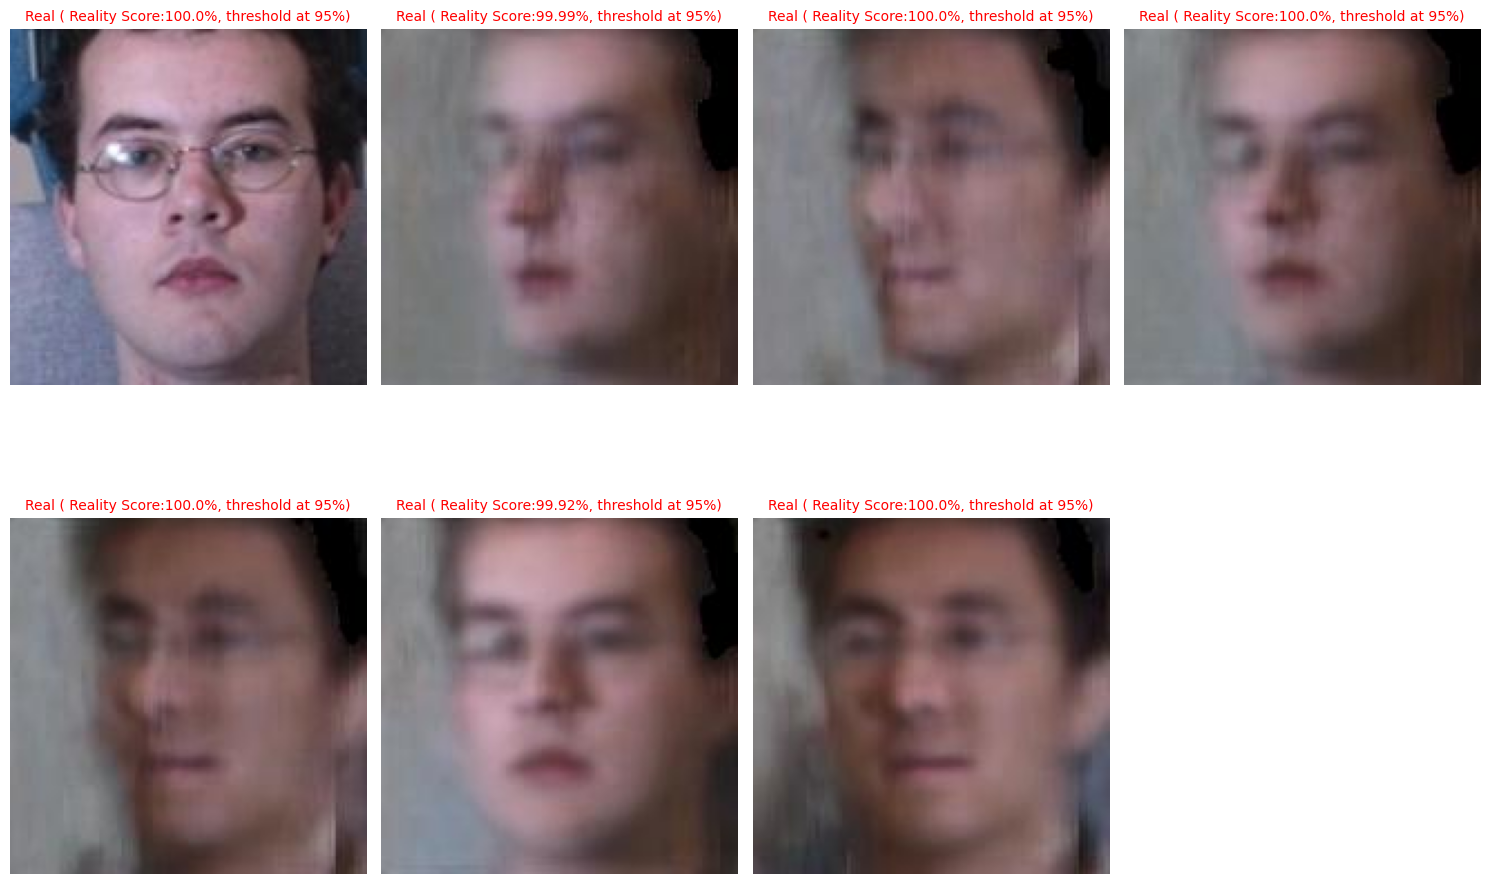

In [17]:
generated_path = '/content/drive/MyDrive/major_project/generated_images/'

img0 = Image.open( generated_path + 'O_B1_i0.jpg').resize((IMG_SIZE,IMG_SIZE), Image.Resampling.LANCZOS)

img1 = Image.open( generated_path + 'R_B1_i0.jpg').resize((IMG_SIZE,IMG_SIZE), Image.Resampling.LANCZOS)
img2 = Image.open( generated_path + 'R_B1_i1.jpg').resize((IMG_SIZE,IMG_SIZE), Image.Resampling.LANCZOS)
img3 = Image.open( generated_path + 'R_B1_i2.jpg').resize((IMG_SIZE,IMG_SIZE), Image.Resampling.LANCZOS)
img4 = Image.open( generated_path + 'R_B1_i3.jpg').resize((IMG_SIZE,IMG_SIZE), Image.Resampling.LANCZOS)
img5 = Image.open( generated_path + 'R_B1_i4.jpg').resize((IMG_SIZE,IMG_SIZE), Image.Resampling.LANCZOS)
img6 = Image.open( generated_path + 'R_B1_i5.jpg').resize((IMG_SIZE,IMG_SIZE), Image.Resampling.LANCZOS)


imgs = list()
imgs.append(img0)
imgs.append(img1)
imgs.append(img2)
imgs.append(img3)
imgs.append(img4)
imgs.append(img5)
imgs.append(img6)


all_photos = np.stack(imgs).astype('uint8')
all_photos = np.array(all_photos / 255, dtype='float32')

X_val = torch.FloatTensor(all_photos)

print(X_val.shape)

print(X_val[0][0][0])
print(X_val[1][0][0])

# torch.Size([12, 160, 160, 3])
# tensor([0.8000, 0.9176, 0.9176])
# tensor([0.6784, 0.7255, 0.7725])



X_val_p = X_val.permute(0, 3, 1, 2).contiguous()

#X_val_p.shape



discriminator_scores = test_discriminator(netD, X_val_p)  # original figure
#discriminator_scores = 1.0 - discriminator_scores

plot_results(imgs,discriminator_scores)

